# Training machine learning models on tabular data: an end-to-end example

This tutorial covers the following steps:
- Import data from your local machine into the Databricks File System (DBFS)
- Visualize the data using Seaborn and matplotlib
- Run a parallel hyperparameter sweep to train machine learning models on the dataset
- Explore the results of the hyperparameter sweep with MLflow
- Register the best performing model in MLflow
- Apply the registered model to another dataset using a Spark UDF
- Set up model serving for low-latency requests

In this example, you build a model to predict the quality of Portugese "Vinho Verde" wine based on the wine's physicochemical properties. 

The example uses a dataset from the UCI Machine Learning Repository, presented in [*Modeling wine preferences by data mining from physicochemical properties*](https://www.sciencedirect.com/science/article/pii/S0167923609001377?via%3Dihub) [Cortez et al., 2009].

## Requirements
This notebook requires Databricks Runtime for Machine Learning.  
If you are using Databricks Runtime 7.3 LTS ML or below, you must update the CloudPickle library. To do that, uncomment and run the `%pip install` command in Cmd 2.

In [0]:
# This command is only required if you are using a cluster running DBR 7.3 LTS ML or below. 
#%pip install --upgrade cloudpickle

## Import data
  
In this section, you download a dataset from the web and upload it to Databricks File System (DBFS).

1. Navigate to https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/ and download both `winequality-red.csv` and `winequality-white.csv` to your local machine.

1. From this Databricks notebook, select *File* > *Upload Data*, and drag these files to the drag-and-drop target to upload them to the Databricks File System (DBFS). 

    **Note**: if you don't have the *File* > *Upload Data* option, you can load the dataset from the Databricks example datasets. Uncomment and run the last two lines in the following cell.

1. Click *Next*. Some auto-generated code to load the data appears. Select *pandas*, and copy the example code. 

1. Create a new cell, then paste in the sample code. It will look similar to the code shown in the following cell. Make these changes:
  - Pass `sep=';'` to `pd.read_csv`
  - Change the variable names from `df1` and `df2` to `white_wine` and `red_wine`, as shown in the following cell.

In [0]:
# If you have the File > Upload Data menu option, follow the instructions in the previous cell to upload the data from your local machine.
# The generated code, including the required edits described in the previous cell, is shown here for reference.

import pandas as pd

# In the following lines, replace <username> with your username.
white_wine = pd.read_csv("/dbfs/FileStore/shared_uploads/<username>/winequality_white.csv", sep=';')
red_wine = pd.read_csv("/dbfs/FileStore/shared_uploads/<username>/winequality_red.csv", sep=';')

# If you do not have the File > Upload Data menu option, uncomment and run these lines to load the dataset.

#white_wine = pd.read_csv("/dbfs/databricks-datasets/wine-quality/winequality-white.csv", sep=";")
#red_wine = pd.read_csv("/dbfs/databricks-datasets/wine-quality/winequality-red.csv", sep=";")

Merge the two DataFrames into a single dataset, with a new binary feature "is_red" that indicates whether the wine is red or white.

In [0]:
red_wine['is_red'] = 1
white_wine['is_red'] = 0

data = pd.concat([red_wine, white_wine], axis=0)

# Remove spaces from column names
data.rename(columns=lambda x: x.replace(' ', '_'), inplace=True)

In [0]:
data.head()

Out[4]:

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality,is_red
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,1
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,1
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,1
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,1
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,1


## Visualize data

Before training a model, explore the dataset using Seaborn and Matplotlib.

Plot a histogram of the dependent variable, quality.

/databricks/python/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
 warnings.warn(msg, FutureWarning)
Out[5]:

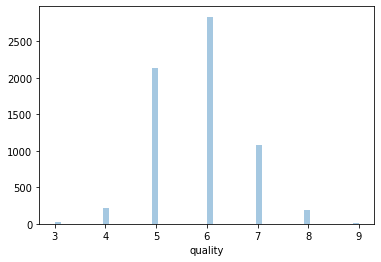

<AxesSubplot:xlabel='quality'>

In [0]:
import seaborn as sns
sns.distplot(data.quality, kde=False)

Looks like quality scores are normally distributed between 3 and 9. 

Define a wine as high quality if it has quality >= 7.

In [0]:
high_quality = (data.quality >= 7).astype(int)
data.quality = high_quality

Box plots are useful in noticing correlations between features and a binary label.

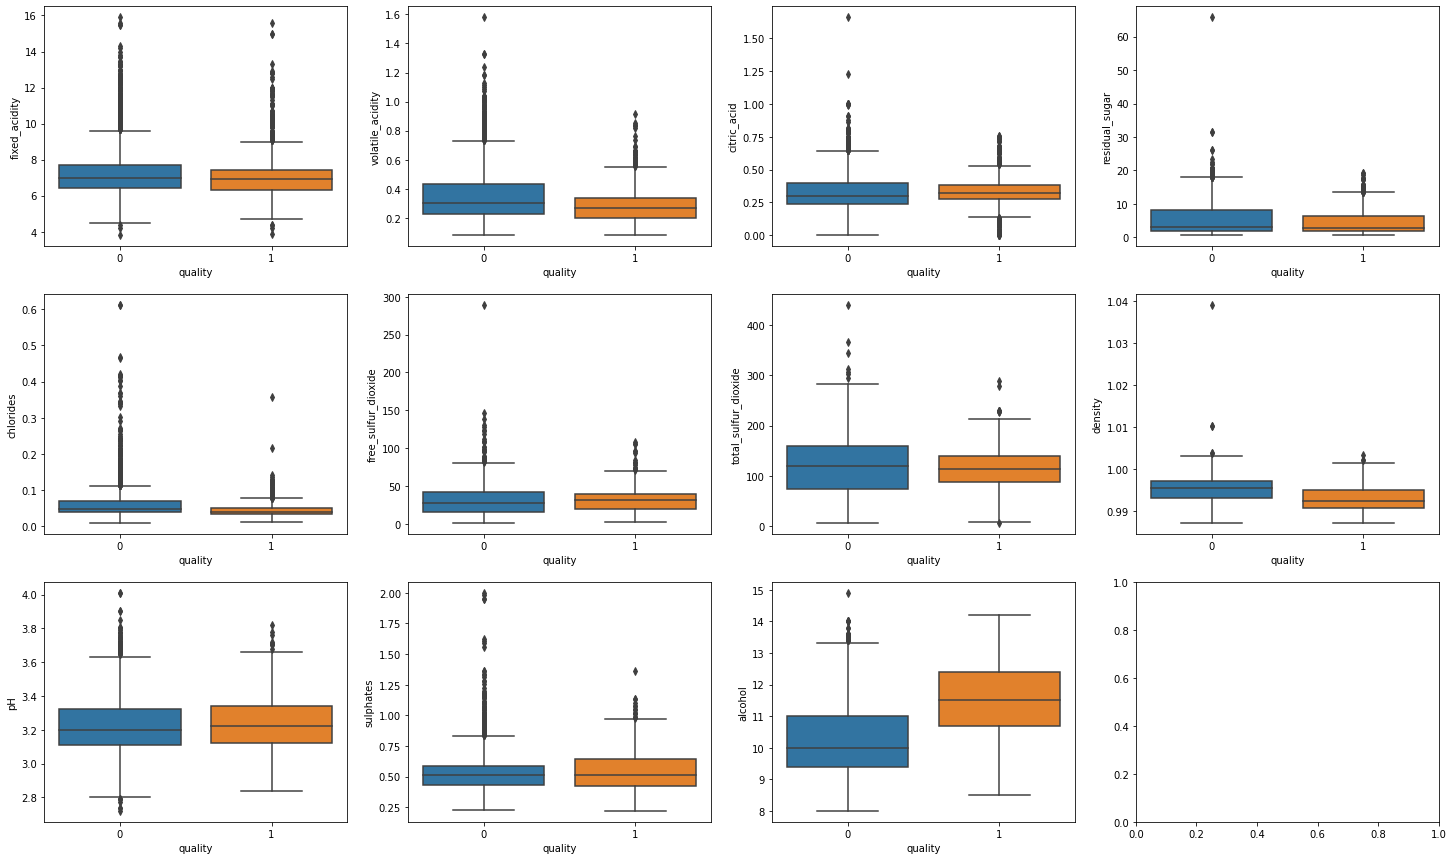

In [0]:
import matplotlib.pyplot as plt

dims = (3, 4)

f, axes = plt.subplots(dims[0], dims[1], figsize=(25, 15))
axis_i, axis_j = 0, 0
for col in data.columns:
  if col == 'is_red' or col == 'quality':
    continue # Box plots cannot be used on indicator variables
  sns.boxplot(x=high_quality, y=data[col], ax=axes[axis_i, axis_j])
  axis_j += 1
  if axis_j == dims[1]:
    axis_i += 1
    axis_j = 0

In the above box plots, a few variables stand out as good univariate predictors of quality. 

- In the alcohol box plot, the median alcohol content of high quality wines is greater than even the 75th quantile of low quality wines. High alcohol content is correlated with quality.
- In the density box plot, low quality wines have a greater density than high quality wines. Density is inversely correlated with quality.

## Preprocess data
Prior to training a model, check for missing values and split the data into training and validation sets.

In [0]:
data.isna().any()

Out[8]: fixed_acidity False
volatile_acidity False
citric_acid False
residual_sugar False
chlorides False
free_sulfur_dioxide False
total_sulfur_dioxide False
density False
pH False
sulphates False
alcohol False
quality False
is_red False
dtype: bool

There are no missing values.

In [0]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(data, random_state=123)
X_train = train.drop(["quality"], axis=1)
X_test = test.drop(["quality"], axis=1)
y_train = train.quality
y_test = test.quality

## Build a baseline model
This task seems well suited to a random forest classifier, since the output is binary and there may be interactions between multiple variables.

The following code builds a simple classifier using scikit-learn. It uses MLflow to keep track of the model accuracy, and to save the model for later use.

In [0]:
import mlflow
import mlflow.pyfunc
import mlflow.sklearn
import numpy as np
import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from mlflow.models.signature import infer_signature
from mlflow.utils.environment import _mlflow_conda_env
import cloudpickle
import time

# The predict method of sklearn's RandomForestClassifier returns a binary classification (0 or 1). 
# The following code creates a wrapper function, SklearnModelWrapper, that uses 
# the predict_proba method to return the probability that the observation belongs to each class. 

class SklearnModelWrapper(mlflow.pyfunc.PythonModel):
  def __init__(self, model):
    self.model = model
    
  def predict(self, context, model_input):
    return self.model.predict_proba(model_input)[:,1]

# mlflow.start_run creates a new MLflow run to track the performance of this model. 
# Within the context, you call mlflow.log_param to keep track of the parameters used, and
# mlflow.log_metric to record metrics like accuracy.
with mlflow.start_run(run_name='untuned_random_forest'):
  n_estimators = 10
  model = RandomForestClassifier(n_estimators=n_estimators, random_state=np.random.RandomState(123))
  model.fit(X_train, y_train)

  # predict_proba returns [prob_negative, prob_positive], so slice the output with [:, 1]
  predictions_test = model.predict_proba(X_test)[:,1]
  auc_score = roc_auc_score(y_test, predictions_test)
  mlflow.log_param('n_estimators', n_estimators)
  # Use the area under the ROC curve as a metric.
  mlflow.log_metric('auc', auc_score)
  wrappedModel = SklearnModelWrapper(model)
  # Log the model with a signature that defines the schema of the model's inputs and outputs. 
  # When the model is deployed, this signature will be used to validate inputs.
  signature = infer_signature(X_train, wrappedModel.predict(None, X_train))
  
  # MLflow contains utilities to create a conda environment used to serve models.
  # The necessary dependencies are added to a conda.yaml file which is logged along with the model.
  conda_env =  _mlflow_conda_env(
        additional_conda_deps=None,
        additional_pip_deps=["cloudpickle=={}".format(cloudpickle.__version__), "scikit-learn=={}".format(sklearn.__version__)],
        additional_conda_channels=None,
    )
  mlflow.pyfunc.log_model("random_forest_model", python_model=wrappedModel, conda_env=conda_env, signature=signature)

/databricks/python/lib/python3.8/site-packages/mlflow/models/signature.py:129: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
 inputs = _infer_schema(model_input)

Examine the learned feature importances output by the model as a sanity-check.

In [0]:
feature_importances = pd.DataFrame(model.feature_importances_, index=X_train.columns.tolist(), columns=['importance'])
feature_importances.sort_values('importance', ascending=False)

Out[11]:

,importance
alcohol,0.162047
density,0.115506
volatile_acidity,0.089138
chlorides,0.082570
pH,0.081632
citric_acid,0.081109
total_sulfur_dioxide,0.081001
sulphates,0.078901
residual_sugar,0.077866
free_sulfur_dioxide,0.076833


As illustrated by the boxplots shown previously, both alcohol and density are important in predicting quality.

You logged the Area Under the ROC Curve (AUC) to MLflow. Click **Experiment** at the upper right to display the Experiment Runs sidebar. 

The model achieved an AUC of 0.89. 

A random classifier would have an AUC of 0.5, and higher AUC values are better. For more information, see [Receiver Operating Characteristic Curve](https://en.wikipedia.org/wiki/Receiver_operating_characteristic#Area_under_the_curve).

#### Register the model in MLflow Model Registry

By registering this model in Model Registry, you can easily reference the model from anywhere within Databricks.

The following section shows how to do this programmatically, but you can also register a model using the UI. See "Create or register a model using the UI" ([AWS](https://docs.databricks.com/applications/machine-learning/manage-model-lifecycle/index.html#create-or-register-a-model-using-the-ui)|[Azure](https://docs.microsoft.com/azure/databricks/applications/machine-learning/manage-model-lifecycle/index#create-or-register-a-model-using-the-ui)|[GCP](https://docs.gcp.databricks.com/applications/machine-learning/manage-model-lifecycle/index.html#create-or-register-a-model-using-the-ui)).

In [0]:
run_id = mlflow.search_runs(filter_string='tags.mlflow.runName = "untuned_random_forest"').iloc[0].run_id

In [0]:
# If you see the error "PERMISSION_DENIED: User does not have any permission level assigned to the registered model", 
# the cause may be that a model already exists with the name "wine_quality". Try using a different name.
model_name = "wine_quality"
model_version = mlflow.register_model(f"runs:/{run_id}/random_forest_model", model_name)

# Registering the model takes a few seconds, so add a small delay
time.sleep(15)

Successfully registered model 'wine_quality'.
2022/01/13 00:13:58 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: wine_quality, version 1
Created version '1' of model 'wine_quality'.

You should now see the model in the Models page. To display the Models page, click the Models icon in the left sidebar. 

Next, transition this model to production and load it into this notebook from Model Registry.

In [0]:
from mlflow.tracking import MlflowClient

client = MlflowClient()
client.transition_model_version_stage(
  name=model_name,
  version=model_version.version,
  stage="Production",
)

Out[14]: <ModelVersion: creation_timestamp=1642032838792, current_stage='Production', description='', last_updated_timestamp=1642032860427, name='wine_quality', run_id='fd8cca9622ba4ee1b1540d61b9406539', run_link='', source='dbfs:/databricks/mlflow-tracking/2910072076440579/fd8cca9622ba4ee1b1540d61b9406539/artifacts/random_forest_model', status='READY', status_message='', tags={}, user_id='1486628617178110', version='1'>

The Models page now shows the model version in stage "Production".

You can now refer to the model using the path "models:/wine_quality/production".

In [0]:
model = mlflow.pyfunc.load_model(f"models:/{model_name}/production")

# Sanity-check: This should match the AUC logged by MLflow
print(f'AUC: {roc_auc_score(y_test, model.predict(X_test))}')

AUC: 0.888902759745664

##Experiment with a new model

The random forest model performed well even without hyperparameter tuning.

The following code uses the xgboost library to train a more accurate model. It runs a parallel hyperparameter sweep to train multiple
models in parallel, using Hyperopt and SparkTrials. As before, the code tracks the performance of each parameter configuration with MLflow.

In [0]:
from hyperopt import fmin, tpe, hp, SparkTrials, Trials, STATUS_OK
from hyperopt.pyll import scope
from math import exp
import mlflow.xgboost
import numpy as np
import xgboost as xgb

search_space = {
  'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),
  'learning_rate': hp.loguniform('learning_rate', -3, 0),
  'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
  'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
  'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
  'objective': 'binary:logistic',
  'seed': 123, # Set a seed for deterministic training
}

def train_model(params):
  # With MLflow autologging, hyperparameters and the trained model are automatically logged to MLflow.
  mlflow.xgboost.autolog()
  with mlflow.start_run(nested=True):
    train = xgb.DMatrix(data=X_train, label=y_train)
    test = xgb.DMatrix(data=X_test, label=y_test)
    # Pass in the test set so xgb can track an evaluation metric. XGBoost terminates training when the evaluation metric
    # is no longer improving.
    booster = xgb.train(params=params, dtrain=train, num_boost_round=1000,\
                        evals=[(test, "test")], early_stopping_rounds=50)
    predictions_test = booster.predict(test)
    auc_score = roc_auc_score(y_test, predictions_test)
    mlflow.log_metric('auc', auc_score)

    signature = infer_signature(X_train, booster.predict(train))
    mlflow.xgboost.log_model(booster, "model", signature=signature)
    
    # Set the loss to -1*auc_score so fmin maximizes the auc_score
    return {'status': STATUS_OK, 'loss': -1*auc_score, 'booster': booster.attributes()}

# Greater parallelism will lead to speedups, but a less optimal hyperparameter sweep. 
# A reasonable value for parallelism is the square root of max_evals.
spark_trials = SparkTrials(parallelism=10)

# Run fmin within an MLflow run context so that each hyperparameter configuration is logged as a child run of a parent
# run called "xgboost_models" .
with mlflow.start_run(run_name='xgboost_models'):
  best_params = fmin(
    fn=train_model, 
    space=search_space, 
    algo=tpe.suggest, 
    max_evals=96,
    trials=spark_trials, 
  )

Hyperopt with SparkTrials will automatically track trials in MLflow. To view the MLflow experiment associated with the notebook, click the 'Runs' icon in the notebook context bar on the upper right. There, you can view all runs.
To view logs from trials, please check the Spark executor logs. To view executor logs, expand 'Spark Jobs' above until you see the (i) icon next to the stage from the trial job. Click it and find the list of tasks. Click the 'stderr' link for a task to view trial logs.
 0%| | 0/96 [00:00<?, ?trial/s, best loss=?] 1%| | 1/96 [00:15<24:12, 15.29s/trial, best loss: -0.9134387201400085] 2%|▏ | 2/96 [00:21<15:24, 9.83s/trial, best loss: -0.9134387201400085] 3%|▎ | 3/96 [00:52<30:21, 19.59s/trial, best loss: -0.918529720886657]  4%|▍ | 4/96 [00:54<19:23, 12.65s/trial, best loss: -0.918529720886657] 5%|▌ | 5/96 [00:55<12:49, 8.45s/trial, best loss: -0.918529720886657] 6%|▋ | 6/96 [00:56<08:52, 5.92s/trial, best loss: -0.918529720886657] 7%|▋ | 7/96 [01:01<08:20, 5.63s/trial, best loss: -0.918529720886657] 8%|▊ | 8/96 [01:02<06:05, 4.15s/trial, best loss: -0.918529720886657] 9%|▉ | 9/96 [01:06<05:57, 4.11s/trial, best loss: -0.918529720886657] 10%|█ | 10/96 [01:10<05:51, 4.08s/trial, best loss: -0.918529720886657] 11%|█▏ | 11/96 [01:34<14:26, 10.19s/trial, best loss: -0.918529720886657] 12%|█▎ | 12/96 [01:43<13:46, 9.84s/trial, best loss: -0.918529720886657] 14%|█▎ | 13/96 [01:51<12:51, 9.30s/trial, best loss: -0.918529720886657] 15%|█▍ | 14/96 [01:54<10:06, 7.40s/trial, best loss: -0.918529720886657] 16%|█▌ | 15/96 [02:32<22:28, 16.65s/trial, best loss: -0.918529720886657] 17%|█▋ | 16/96 [02:43<19:56, 14.96s/trial, best loss: -0.918529720886657] 18%|█▊ | 17/96 [02:44<14:13, 10.80s/trial, best loss: -0.9189981595354609] 19%|█▉ | 18/96 [03:03<16:56, 13.03s/trial, best loss: -0.9230690578438506] 20%|█▉ | 19/96 [03:16<16:43, 13.03s/trial, best loss: -0.9230690578438506] 21%|██ | 20/96 [03:23<14:13, 11.23s/trial, best loss: -0.9230690578438506] 22%|██▏ | 21/96 [03:30<12:27, 9.97s/trial, best loss: -0.9230690578438506] 23%|██▎ | 22/96 [03:41<12:41, 10.29s/trial, best loss: -0.9230690578438506] 24%|██▍ | 23/96 [03:46<10:36, 8.71s/trial, best loss: -0.9230690578438506] 25%|██▌ | 24/96 [04:35<24:59, 20.82s/trial, best loss: -0.9230690578438506] 26%|██▌ | 25/96 [04:52<23:17, 19.69s/trial, best loss: -0.9230690578438506] 28%|██▊ | 27/96 [04:58<13:47, 11.99s/trial, best loss: -0.9230690578438506] 29%|██▉ | 28/96 [05:01<11:05, 9.79s/trial, best loss: -0.9230690578438506] 30%|███ | 29/96 [05:04<08:57, 8.03s/trial, best loss: -0.9230690578438506] 31%|███▏ | 30/96 [05:07<07:20, 6.67s/trial, best loss: -0.9230690578438506] 32%|███▏ | 31/96 [05:09<05:49, 5.37s/trial, best loss: -0.9230690578438506] 33%|███▎ | 32/96 [05:10<04:23, 4.12s/trial, best loss: -0.9230690578438506] 34%|███▍ | 33/96 [05:11<03:23, 3.23s/trial, best loss: -0.9230690578438506] 35%|███▌ | 34/96 [05:13<02:58, 2.88s/trial, best loss: -0.9230690578438506] 36%|███▋ | 35/96 [05:18<03:34, 3.52s/trial, best loss: -0.9230690578438506] 38%|███▊ | 36/96 [05:21<03:22, 3.37s/trial, best loss: -0.9230690578438506] 39%|███▊ | 37/96 [05:22<02:37, 2.67s/trial, best loss: -0.9230690578438506] 40%|███▉ | 38/96 [05:23<02:06, 2.18s/trial, best loss: -0.9230690578438506] 42%|████▏ | 40/96 [05:24<01:18, 1.41s/trial, best loss: -0.9230690578438506] 44%|████▍ | 42/96 [05:29<01:29, 1.66s/trial, best loss: -0.9230690578438506] 45%|████▍ | 43/96 [05:30<01:20, 1.52s/trial, best loss: -0.9230690578438506] 46%|████▌ | 44/96 [05:33<01:38, 1.89s/trial, best loss: -0.9230690578438506] 47%|████▋ | 45/96 [05:35<01:38, 1.92s/trial, best loss: -0.9230690578438506] 49%|████▉ | 47/96 [05:36<01:04, 1.32s/trial, best loss: -0.9230690578438506] 50%|█████ | 48/96 [05:37<01:00, 1.26s/trial, best loss: -0.9230690578438506] 51%|█████ | 49/96 [05:38<00:56, 1.20s/trial, best loss: -0.9230690578438506] 52%|█████▏ | 50/96 [05:39<00:53, 1.16s/trial, best loss: 

#### Use MLflow to view the results
Open up the Experiment Runs sidebar to see the MLflow runs. Click on Date next to the down arrow to display a menu, and select 'auc' to display the runs sorted by the auc metric. The highest auc value is 0.91. You beat the baseline!

MLflow tracks the parameters and performance metrics of each run. Click the External Link icon <img src="https://docs.databricks.com/_static/images/icons/external-link.png"/> at the top of the Experiment Runs sidebar to navigate to the MLflow Runs Table.

Now investigate how the hyperparameter choice correlates with AUC. Click the "+" icon to expand the parent run, then select all runs except the parent, and click "Compare". Select the Parallel Coordinates Plot.

The Parallel Coordinates Plot is useful in understanding the impact of parameters on a metric. You can drag the pink slider bar at the upper right corner of the plot to highlight a subset of AUC values and the corresponding parameter values. The plot below highlights the highest AUC values:

<img src="https://docs.databricks.com/_static/images/mlflow/end-to-end-example/parallel-coordinates-plot.png"/>

Notice that all of the top performing runs have a low value for reg_lambda and learning_rate. 

You could run another hyperparameter sweep to explore even lower values for these parameters. For simplicity, that step is not included in this example.

You used MLflow to log the model produced by each hyperparameter configuration. The following code finds the best performing run and saves the model to Model Registry.

In [0]:
best_run = mlflow.search_runs(order_by=['metrics.auc DESC']).iloc[0]
print(f'AUC of Best Run: {best_run["metrics.auc"]}')

AUC of Best Run: 0.9230690578438506

#### Update the production `wine_quality` model in MLflow Model Registry

Earlier, you saved the baseline model to Model Registry with the name `wine_quality`. Now that you have a created a more accurate model, update `wine_quality`.

In [0]:
new_model_version = mlflow.register_model(f"runs:/{best_run.run_id}/model", model_name)

# Registering the model takes a few seconds, so add a small delay
time.sleep(15)

Registered model 'wine_quality' already exists. Creating a new version of this model...
2022/01/13 00:22:20 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: wine_quality, version 2
Created version '2' of model 'wine_quality'.

Click **Models** in the left sidebar to see that the `wine_quality` model now has two versions. 

The following code promotes the new version to production.

In [0]:
# Archive the old model version
client.transition_model_version_stage(
  name=model_name,
  version=model_version.version,
  stage="Archived"
)

# Promote the new model version to Production
client.transition_model_version_stage(
  name=model_name,
  version=new_model_version.version,
  stage="Production"
)

Out[19]: <ModelVersion: creation_timestamp=1642033340364, current_stage='Production', description='', last_updated_timestamp=1642033362056, name='wine_quality', run_id='5f47272f8682420c81d2cba15889fc1d', run_link='', source='dbfs:/databricks/mlflow-tracking/2910072076440579/5f47272f8682420c81d2cba15889fc1d/artifacts/model', status='READY', status_message='', tags={}, user_id='1486628617178110', version='2'>

Clients that call load_model now receive the new model.

In [0]:
# This code is the same as the last block of "Building a Baseline Model". No change is required for clients to get the new model!
model = mlflow.pyfunc.load_model(f"models:/{model_name}/production")
print(f'AUC: {roc_auc_score(y_test, model.predict(X_test))}')

AUC: 0.9230690578438506

##Batch inference

There are many scenarios where you might want to evaluate a model on a corpus of new data. For example, you may have a fresh batch of data, or may need to compare the performance of two models on the same corpus of data.

The following code evaluates the model on data stored in a Delta table, using Spark to run the computation in parallel.

In [0]:
# To simulate a new corpus of data, save the existing X_train data to a Delta table. 
# In the real world, this would be a new batch of data.
spark_df = spark.createDataFrame(X_train)
# Replace <username> with your username before running this cell.
table_path = "dbfs:/<username>/delta/wine_data"
# Delete the contents of this path in case this cell has already been run
dbutils.fs.rm(table_path, True)
spark_df.write.format("delta").save(table_path)

Load the model into a Spark UDF, so it can be applied to the Delta table.

In [0]:
import mlflow.pyfunc

apply_model_udf = mlflow.pyfunc.spark_udf(spark, f"models:/{model_name}/production")

In [0]:
# Read the "new data" from Delta
new_data = spark.read.format("delta").load(table_path)

In [0]:
display(new_data)

fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,is_red
7.2,0.23,0.39,2.3,0.033,29.0,102.0,0.9908,3.26,0.54,12.3,0
6.4,0.24,0.27,1.5,0.04,35.0,105.0,0.98914,3.13,0.3,12.4,0
7.4,0.24,0.29,10.1,0.05,21.0,105.0,0.9962,3.13,0.35,9.5,0
8.6,0.37,0.65,6.4,0.08,3.0,8.0,0.99817,3.27,0.58,11.0,1
5.9,0.32,0.39,3.3,0.114,24.0,140.0,0.9934,3.09,0.45,9.2,0
7.0,0.42,0.35,1.6,0.088,16.0,39.0,0.9961,3.34,0.55,9.2,1
6.7,0.31,0.44,6.7,0.054,29.0,160.0,0.9952,3.04,0.44,9.6,0
8.1,0.545,0.18,1.9,0.08,13.0,35.0,0.9972,3.3,0.59,9.0,1
6.3,0.41,0.3,3.2,0.03,49.0,164.0,0.9927,3.53,0.79,11.7,0
7.3,0.49,0.32,5.2,0.043,18.0,104.0,0.9952,3.24,0.45,10.7,0


In [0]:
from pyspark.sql.functions import struct

# Apply the model to the new data
udf_inputs = struct(*(X_train.columns.tolist()))

new_data = new_data.withColumn(
  "prediction",
  apply_model_udf(udf_inputs)
)

In [0]:
# Each row now has an associated prediction. Note that the xgboost function does not output probabilities by default, so the predictions are not limited to the range [0, 1].
display(new_data)

fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,is_red,prediction
7.2,0.23,0.39,2.3,0.033,29.0,102.0,0.9908,3.26,0.54,12.3,0,0.9751631617546082
6.4,0.24,0.27,1.5,0.04,35.0,105.0,0.98914,3.13,0.3,12.4,0,0.01992025412619114
7.4,0.24,0.29,10.1,0.05,21.0,105.0,0.9962,3.13,0.35,9.5,0,7.046426762826741E-4
8.6,0.37,0.65,6.4,0.08,3.0,8.0,0.99817,3.27,0.58,11.0,1,0.011003587394952774
5.9,0.32,0.39,3.3,0.114,24.0,140.0,0.9934,3.09,0.45,9.2,0,0.00361012015491724
7.0,0.42,0.35,1.6,0.088,16.0,39.0,0.9961,3.34,0.55,9.2,1,0.0010293669765815139
6.7,0.31,0.44,6.7,0.054,29.0,160.0,0.9952,3.04,0.44,9.6,0,0.0010825126664713025
8.1,0.545,0.18,1.9,0.08,13.0,35.0,0.9972,3.3,0.59,9.0,1,0.0016736732795834541
6.3,0.41,0.3,3.2,0.03,49.0,164.0,0.9927,3.53,0.79,11.7,0,0.9625353217124939
7.3,0.49,0.32,5.2,0.043,18.0,104.0,0.9952,3.24,0.45,10.7,0,0.012135892175137997


## Model serving

To productionize the model for low latency predictions, use MLflow Model Serving ([AWS](https://docs.databricks.com/applications/mlflow/model-serving.html)|[Azure](https://docs.microsoft.com/azure/databricks/applications/mlflow/model-serving)|[GCP](https://docs.gcp.databricks.com/applications/mlflow/model-serving.html)) to deploy the model to an endpoint.

The following code illustrates how to issue requests using a REST API to get predictions from the deployed model.

d
You need a Databricks token to issue requests to your model endpoint. You can generate a token from the User Settings page (click Settings in the left sidebar). Copy the token into the next cell.

In [0]:
import os
os.environ["DATABRICKS_TOKEN"] = "<YOUR_TOKEN>"

Click **Models** in the left sidebar and navigate to the registered wine model. Click the serving tab, and then click **Enable Serving**.

Then, under **Call The Model**, click the **Python** button to display a Python code snippet to issue requests. Copy the code into this notebook. It should look similar to the code in the next cell. 

You can use the token to make these requests from outside Databricks notebooks as well.

In [0]:
# Replace with code snippet from the model serving page
import os
import requests
import pandas as pd

def score_model(dataset: pd.DataFrame):
  url = 'https://<DATABRICKS_URL>/model/wine_quality/Production/invocations'
  headers = {'Authorization': f'Bearer {os.environ.get("DATABRICKS_TOKEN")}'}
  data_json = dataset.to_dict(orient='split')
  response = requests.request(method='POST', headers=headers, url=url, json=data_json)
  if response.status_code != 200:
    raise Exception(f'Request failed with status {response.status_code}, {response.text}')
  return response.json()

The model predictions from the endpoint should agree with the results from locally evaluating the model.

In [0]:
# Model serving is designed for low-latency predictions on smaller batches of data
num_predictions = 5
served_predictions = score_model(X_test[:num_predictions])
model_evaluations = model.predict(X_test[:num_predictions])
# Compare the results from the deployed model and the trained model
pd.DataFrame({
  "Model Prediction": model_evaluations,
  "Served Model Prediction": served_predictions,
})